<a href="https://colab.research.google.com/github/TITAN-Project-EU/PhotoZ_SDSS_ML/blob/main/MLP_PhotoZ_SDSS_Uncertainty_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Global parameters
FIGSIZE_SINGLE = (8, 6)
FIGSIZE_DOUBLE = (12, 5)
FIGSIZE_TRIPLE = (18, 5)
MAX_POINTS = 30000  # For plotting performance

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# DATA LOADING AND PREPROCESSING
# ═══════════════════════════════════════════════════════════════════════════════

print("\n1. Loading and preprocessing data...")

# Load your data (adjust URL/path as needed)
url = 'https://zenodo.org/records/11073039/files/PhotoZ_SDSS.csv'
data_raw = pd.read_csv(url)

# Data cleaning
data = data_raw[(data_raw['u'] >= 0) & (data_raw['g'] >= 0) &
                (data_raw['r'] >= 0) & (data_raw['i'] >= 0) &
                (data_raw['redshift'] >= 0.01)]
data = data.dropna(subset=['u', 'g', 'r', 'i', 'redshift'])

# Features and target
X = data[['u', 'g', 'r', 'i']]
y = data['redshift']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Target range: [{y.min():.3f}, {y.max():.3f}]")


1. Loading and preprocessing data...
Training set: (794515, 4)
Test set: (198629, 4)
Target range: [0.010, 0.309]


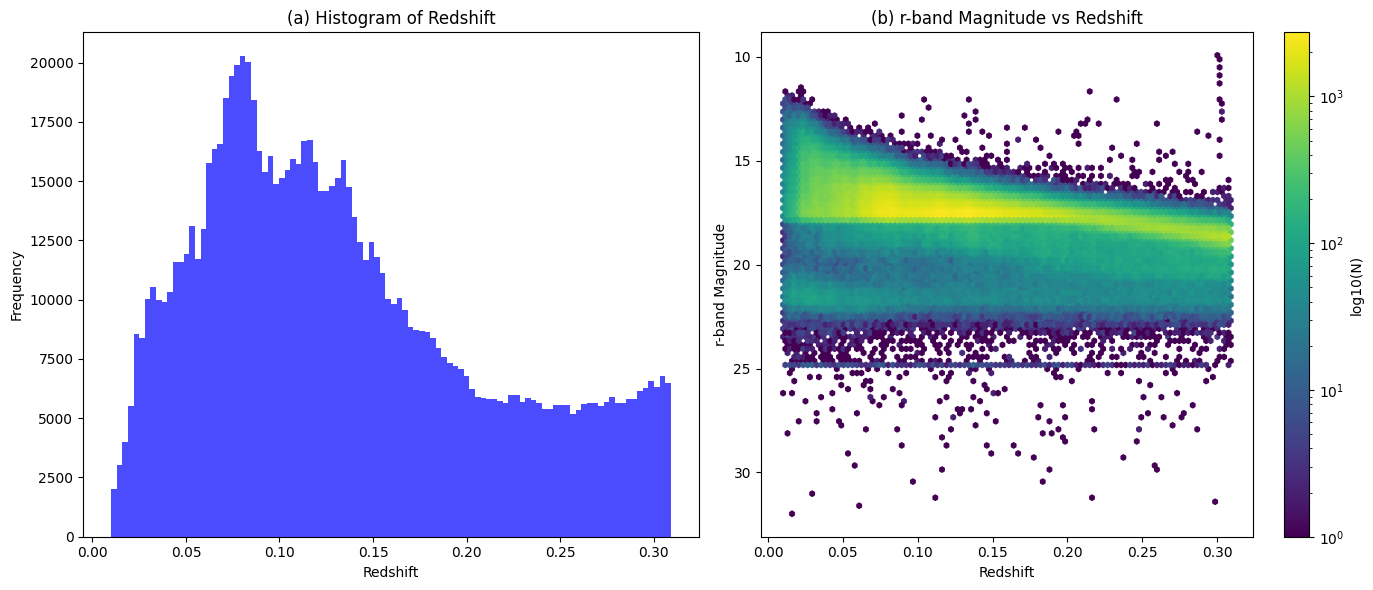

In [3]:
# Side-by-side plots with subcaptions

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# (a) Histogram of redshift
axes[0].hist(data['redshift'].dropna().to_numpy(), bins=100, color='blue', alpha=0.7)
axes[0].set_title('(a) Histogram of Redshift')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('Frequency')

# (b) r-band magnitude vs redshift hexbin
hb = axes[1].hexbin(
    data['redshift'], data['r'],
    gridsize=100, cmap='viridis', bins='log'
)
axes[1].set_title('(b) r-band Magnitude vs Redshift')
axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('r-band Magnitude')
axes[1].invert_yaxis()

# Shared colorbar
cb = fig.colorbar(hb, ax=axes[1])
cb.set_label('log10(N)')

plt.tight_layout()
plt.show()


In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# UTILITY FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def subsample_for_plot(y_true, y_pred, uncertainty=None, max_points=MAX_POINTS):
    """Subsample data for plotting"""
    if len(y_true) > max_points:
        idx = np.random.choice(len(y_true), size=max_points, replace=False)

        # Corrected indexing logic: Use .iloc for pandas Series, standard indexing for numpy
        if isinstance(y_true, pd.Series):
            y_true_sub = y_true.iloc[idx]
        else:
            y_true_sub = y_true[idx]

        if isinstance(y_pred, pd.Series):
            y_pred_sub = y_pred.iloc[idx]
        else:
            y_pred_sub = y_pred[idx]

        if uncertainty is not None:
            if isinstance(uncertainty, pd.Series):
                uncertainty_sub = uncertainty.iloc[idx]
            else:
                uncertainty_sub = uncertainty[idx]
        else:
            uncertainty_sub = None

    else:
        y_true_sub, y_pred_sub, uncertainty_sub = y_true, y_pred, uncertainty
    return y_true_sub, y_pred_sub, uncertainty_sub

def calculate_coverage(y_true, lower, upper, confidence_level):
    """Calculate interval coverage"""
    in_interval = (y_true >= lower) & (y_true <= upper)
    return np.mean(in_interval)

def plot_uncertainty_method(y_true, y_pred, uncertainty, method_name, uncertainty_type):
    """Plot individual uncertainty method results"""

    # Subsample for plotting
    yt_sub, yp_sub, unc_sub = subsample_for_plot(y_true, y_pred, uncertainty, max_points=5000)

    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)

    # Plot 1: Predictions colored by uncertainty
    if unc_sub is not None:
        norm = Normalize(vmin=np.percentile(unc_sub, 5), vmax=np.percentile(unc_sub, 95))
        scatter = axes[0].scatter(yt_sub, yp_sub, c=unc_sub, cmap='viridis',
                                 s=6, alpha=0.6, norm=norm)
        cbar = plt.colorbar(scatter, ax=axes[0])
        cbar.set_label(f'{uncertainty_type} Uncertainty')
    else:
        axes[0].scatter(yt_sub, yp_sub, s=6, alpha=0.6, color='blue')

    # 1:1 line
    # lims = [yt_sub.min(), yt_sub.max()]
    lims = [0, 0.3]
    axes[0].plot(lims, lims, 'k--', lw=1)

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    axes[0].set_title(f'{method_name}\nMAE: {mae:.4f}, R²: {r2:.3f}')
    axes[0].set_xlabel('True redshift')
    axes[0].set_ylabel('Predicted redshift')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Uncertainty vs Error
    if unc_sub is not None:
        errors = np.abs(yt_sub - yp_sub)
        correlation = np.corrcoef(errors, unc_sub)[0, 1] if len(set(unc_sub)) > 1 else 0

        axes[1].scatter(unc_sub, errors, s=4, alpha=0.6)

        # Trend line
        if correlation != 0:
            z = np.polyfit(unc_sub, errors, 1)
            p = np.poly1d(z)
            axes[1].plot(unc_sub, p(unc_sub), "r--", alpha=0.8)

        axes[1].set_xlabel(f'{uncertainty_type} Uncertainty')
        axes[1].set_ylabel('Prediction Error')
        axes[1].set_title(f'Uncertainty vs Error\nCorrelation: {correlation:.3f}')
        axes[1].grid(True, alpha=0.3)

        # Plot 3: Uncertainty distribution
        axes[2].hist(unc_sub, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[2].axvline(np.median(unc_sub), color='red', linestyle='--',
                       label=f'Median = {np.median(unc_sub):.4f}')
        axes[2].set_xlabel(f'{uncertainty_type} Uncertainty')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Uncertainty Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No Uncertainty\nEstimate', transform=axes[1].transAxes,
                    ha='center', va='center', fontsize=14)
        axes[1].set_title('Baseline Model')
        axes[2].text(0.5, 0.5, 'Point\nEstimation\nOnly', transform=axes[2].transAxes,
                    ha='center', va='center', fontsize=14)
        axes[2].set_title('No Uncertainty')

    plt.suptitle(f'{method_name} - {uncertainty_type} Uncertainty Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# BASELINE: POINT ESTIMATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n2. Training BASELINE model (no uncertainty)...")

def create_baseline_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    return model

# Train baseline model
baseline_model = create_baseline_model(X_train_scaled.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
baseline_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    epochs=20, batch_size=1024, validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=2
)

baseline_pred = baseline_model.predict(X_test_scaled, verbose=2).flatten()
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"Baseline MAE: {baseline_mae:.4f}")



2. Training BASELINE model (no uncertainty)...
Epoch 1/20
621/621 - 12s - 20ms/step - loss: 0.0020 - mae: 0.0303 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 2/20
621/621 - 1s - 2ms/step - loss: 0.0011 - mae: 0.0228 - val_loss: 0.0010 - val_mae: 0.0222
Epoch 3/20
621/621 - 1s - 2ms/step - loss: 9.6847e-04 - mae: 0.0217 - val_loss: 9.3707e-04 - val_mae: 0.0214
Epoch 4/20
621/621 - 1s - 2ms/step - loss: 9.2390e-04 - mae: 0.0211 - val_loss: 9.0661e-04 - val_mae: 0.0210
Epoch 5/20
621/621 - 1s - 2ms/step - loss: 9.0127e-04 - mae: 0.0208 - val_loss: 8.8920e-04 - val_mae: 0.0207
Epoch 6/20
621/621 - 1s - 2ms/step - loss: 8.8710e-04 - mae: 0.0206 - val_loss: 8.7639e-04 - val_mae: 0.0205
Epoch 7/20
621/621 - 1s - 2ms/step - loss: 8.7676e-04 - mae: 0.0204 - val_loss: 8.6757e-04 - val_mae: 0.0204
Epoch 8/20
621/621 - 1s - 2ms/step - loss: 8.6882e-04 - mae: 0.0203 - val_loss: 8.6054e-04 - val_mae: 0.0203
Epoch 9/20
621/621 - 1s - 2ms/step - loss: 8.6222e-04 - mae: 0.0202 - val_loss: 8.5514e-04 - v

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# Get predictions from the trained regression model
y_pred_reg = baseline_model.predict(X_test_scaled, batch_size=1024)

# 1) Ensure both vectors are 1-D NumPy arrays (positional indexing)
y_true = np.asarray(y_test)        # true spec-z
y_pred = np.asarray(y_pred_reg)    # regression predictions

assert len(y_true) == len(y_pred), "Length mismatch between y_test and y_pred_reg!"

# ------------------------------------------------------------------
# 2) Optional sub-sample to lighten the plot
max_pts = 60_000          # set higher or comment out to plot everything
if len(y_true) > max_pts:
    rng   = np.random.default_rng(42)          # fixed seed → reproducible
    keep  = rng.choice(len(y_true), size=max_pts, replace=False)
    yt, yp = y_true[keep], y_pred[keep]
else:
    yt, yp = y_true, y_pred

194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


Regression performance metrics
----------------------------------
Mean Absolute Error      (MAE) : 0.01967
Root Mean Squared Error  (RMSE): 0.02864
R² score                       : 0.85824


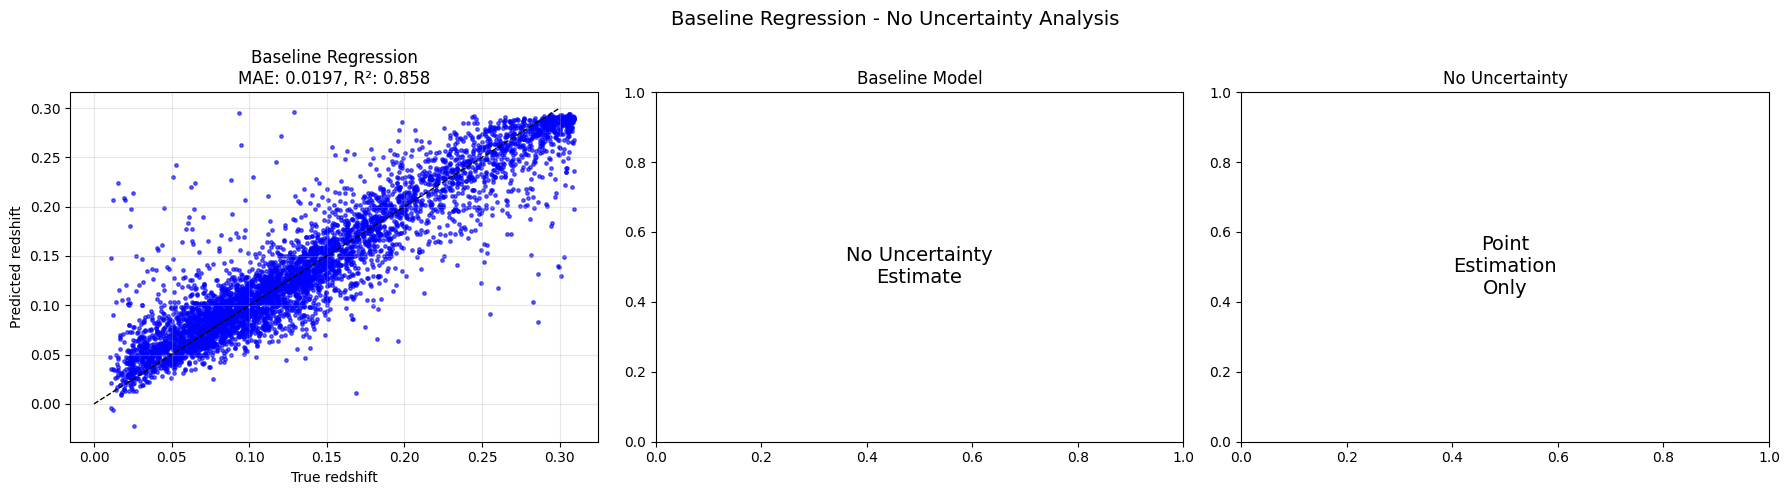

In [7]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
    explained_variance_score
)
import numpy as np

# ------------------------------------------------------------------
# 1) Ensure NumPy arrays for positional consistency
y_true = np.asarray(y_test)        # true spec-z
y_pred = np.asarray(y_pred_reg)    # model predictions

# ------------------------------------------------------------------
# 2) Core metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)


# ------------------------------------------------------------------
# 3) Print nicely
print("Regression performance metrics")
print("-" * 34)
print(f"Mean Absolute Error      (MAE) : {mae:.5f}")
print(f"Root Mean Squared Error  (RMSE): {rmse:.5f}")
print(f"R² score                       : {r2:.5f}")

plot_uncertainty_method(y_test, baseline_pred, None, "Baseline Regression", "No")

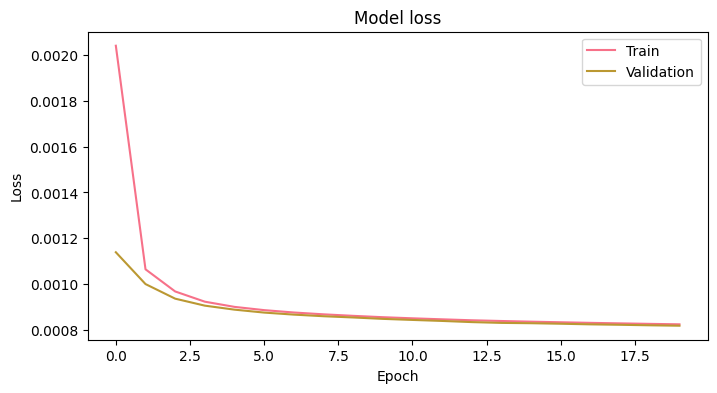

In [8]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(baseline_history.history['loss'], label='Train')
plt.plot(baseline_history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# Gaussian NLL
# ═══════════════════════════════════════════════════════════════════════════════

print("\n6. Training Gaussian NLL")

def create_gaussian_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    mean_output = layers.Dense(1, name='mean')(x)
    log_std_output = layers.Dense(1, name='log_std')(x)

    outputs = layers.Concatenate()([mean_output, log_std_output])
    return models.Model(inputs, outputs)

def gaussian_nll_loss(y_true, y_pred):
    mean = y_pred[:, 0:1]
    log_std = y_pred[:, 1:2]
    std = tf.exp(log_std) + 1e-3
    std = tf.clip_by_value(std, 1e-3, 1.0)  # Prevent collapse

    nll = 0.5 * tf.math.log(2.0 * np.pi) + tf.math.log(std) + 0.5 * tf.square((y_true - mean) / std)
    sigma_reg = 0.01 * tf.square(std - 0.05)  # Regularization

    return tf.reduce_mean(nll + sigma_reg)

gaussian_model = create_gaussian_model(X_train_scaled.shape[1])
gaussian_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=gaussian_nll_loss, metrics=['mae'])

gaussian_history = gaussian_model.fit(
    X_train_scaled, y_train,
    epochs=20, batch_size=1024, validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=2
)


6. Training Gaussian NLL
Epoch 1/20
621/621 - 7s - 11ms/step - loss: -9.7609e-01 - mae: 1.2354 - val_loss: -2.0165e+00 - val_mae: 1.7244
Epoch 2/20
621/621 - 2s - 2ms/step - loss: -2.0037e+00 - mae: 1.7947 - val_loss: -2.1569e+00 - val_mae: 1.8171
Epoch 3/20
621/621 - 2s - 2ms/step - loss: -2.0988e+00 - mae: 1.8459 - val_loss: -2.2360e+00 - val_mae: 1.8635
Epoch 4/20
621/621 - 2s - 2ms/step - loss: -2.1407e+00 - mae: 1.8687 - val_loss: -2.2537e+00 - val_mae: 1.8598
Epoch 5/20
621/621 - 2s - 2ms/step - loss: -2.1857e+00 - mae: 1.8936 - val_loss: -2.2837e+00 - val_mae: 1.8819
Epoch 6/20
621/621 - 2s - 2ms/step - loss: -2.2122e+00 - mae: 1.9085 - val_loss: -2.3085e+00 - val_mae: 1.9119
Epoch 7/20
621/621 - 2s - 2ms/step - loss: -2.2339e+00 - mae: 1.9208 - val_loss: -2.3175e+00 - val_mae: 1.9114
Epoch 8/20
621/621 - 2s - 2ms/step - loss: -2.2491e+00 - mae: 1.9292 - val_loss: -2.3226e+00 - val_mae: 1.9148
Epoch 9/20
621/621 - 2s - 2ms/step - loss: -2.2647e+00 - mae: 1.9377 - val_loss: -2.3

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Gaussian NLL MAE: 0.0195
Mean Aleatoric σ: 0.0269


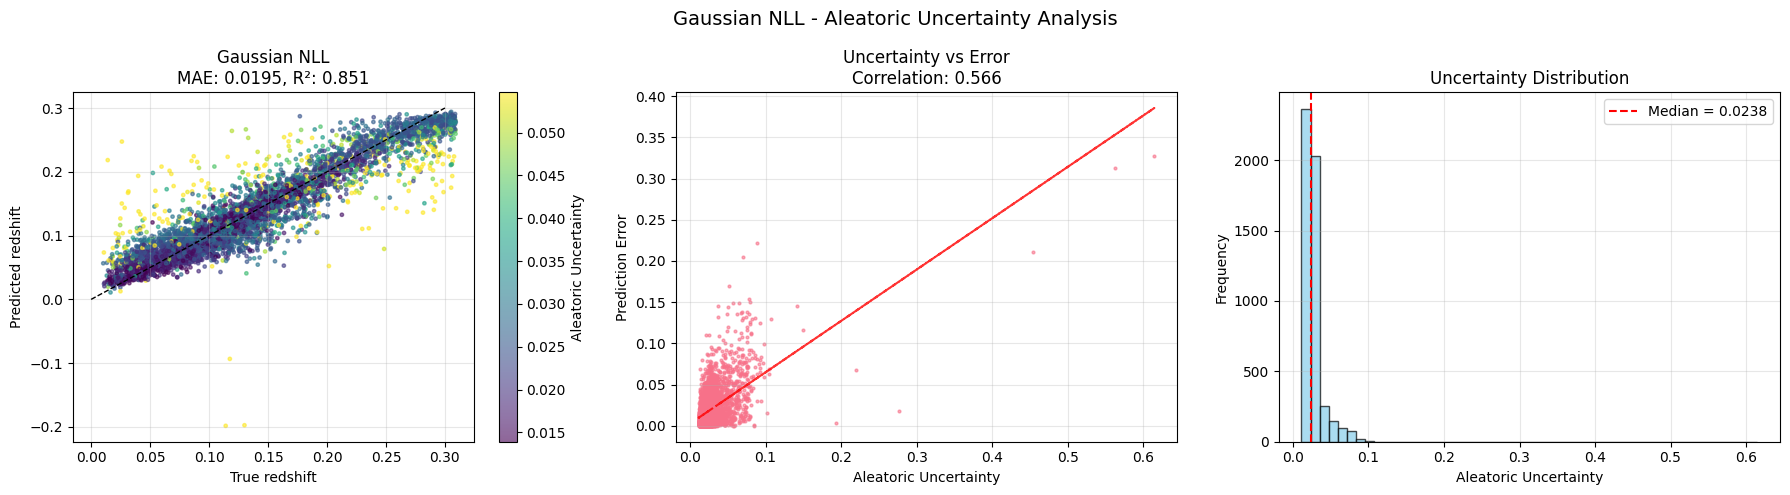

In [10]:
# Gaussian predictions (aleatoric uncertainty)
gaussian_pred = gaussian_model.predict(X_test_scaled, batch_size=1024)
gaussian_mean_pred = gaussian_pred[:, 0]
gaussian_aleatoric_uncertainty = np.exp(gaussian_pred[:, 1]) + 1e-3
gaussian_aleatoric_uncertainty = np.clip(gaussian_aleatoric_uncertainty, 1e-3, 1.0)

print(f"Gaussian NLL MAE: {mean_absolute_error(y_test, gaussian_mean_pred):.4f}")
print(f"Mean Aleatoric σ: {np.mean(gaussian_aleatoric_uncertainty):.4f}")

# Plot Gaussian results
plot_uncertainty_method(y_test, gaussian_mean_pred, gaussian_aleatoric_uncertainty,
                       "Gaussian NLL", "Aleatoric")

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# Quantile Regression
# ═══════════════════════════════════════════════════════════════════════════════

print("\n7. Training Quantile Regression")

def create_quantile_model(input_dim, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    # Predict median + spreads (ensures ordering)
    median = layers.Dense(1, name='median')(x)
    lower_spread_25 = layers.Dense(1, activation='softplus')(x)
    lower_spread_05 = layers.Dense(1, activation='softplus')(x)
    upper_spread_25 = layers.Dense(1, activation='softplus')(x)
    upper_spread_05 = layers.Dense(1, activation='softplus')(x)

    # Add minimum spreads
    lower_spread_25 = layers.Lambda(lambda x: x + 0.005)(lower_spread_25)
    lower_spread_05 = layers.Lambda(lambda x: x + 0.005)(lower_spread_05)
    upper_spread_25 = layers.Lambda(lambda x: x + 0.005)(upper_spread_25)
    upper_spread_05 = layers.Lambda(lambda x: x + 0.005)(upper_spread_05)

    # Construct quantiles
    q05 = layers.Subtract()([layers.Subtract()([median, lower_spread_25]), lower_spread_05])
    q25 = layers.Subtract()([median, lower_spread_25])
    q50 = median
    q75 = layers.Add()([median, upper_spread_25])
    q95 = layers.Add()([layers.Add()([median, upper_spread_25]), upper_spread_05])

    outputs = layers.Concatenate()([q05, q25, q50, q75, q95])
    return models.Model(inputs, outputs)

def quantile_loss(y_true, y_pred, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    total_loss = 0.0
    for i, q in enumerate(quantiles):
        error = y_true - y_pred[:, i:i+1]
        loss = tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
        total_loss += loss
    return total_loss / len(quantiles)

quantile_model = create_quantile_model(X_train_scaled.shape[1])
quantile_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=quantile_loss, metrics=['mae'])

quantile_history = quantile_model.fit(
    X_train_scaled, y_train,
    epochs=20, batch_size=1024, validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=2
)




7. Training Quantile Regression
Epoch 1/20
621/621 - 9s - 15ms/step - loss: 0.0155 - mae: 0.0957 - val_loss: 0.0070 - val_mae: 0.0351
Epoch 2/20
621/621 - 2s - 3ms/step - loss: 0.0074 - mae: 0.0358 - val_loss: 0.0067 - val_mae: 0.0336
Epoch 3/20
621/621 - 2s - 3ms/step - loss: 0.0071 - mae: 0.0342 - val_loss: 0.0065 - val_mae: 0.0324
Epoch 4/20
621/621 - 2s - 3ms/step - loss: 0.0069 - mae: 0.0333 - val_loss: 0.0064 - val_mae: 0.0317
Epoch 5/20
621/621 - 2s - 3ms/step - loss: 0.0067 - mae: 0.0327 - val_loss: 0.0063 - val_mae: 0.0312
Epoch 6/20
621/621 - 2s - 3ms/step - loss: 0.0066 - mae: 0.0323 - val_loss: 0.0062 - val_mae: 0.0307
Epoch 7/20
621/621 - 2s - 3ms/step - loss: 0.0066 - mae: 0.0320 - val_loss: 0.0062 - val_mae: 0.0307
Epoch 8/20
621/621 - 2s - 3ms/step - loss: 0.0065 - mae: 0.0318 - val_loss: 0.0062 - val_mae: 0.0307
Epoch 9/20
621/621 - 2s - 3ms/step - loss: 0.0065 - mae: 0.0316 - val_loss: 0.0062 - val_mae: 0.0306
Epoch 10/20
621/621 - 2s - 3ms/step - loss: 0.0064 - mae:

Quantile Regression MAE: 0.0191
90% Coverage: 0.911
Mean Aleatoric σ (IQR): 0.0301


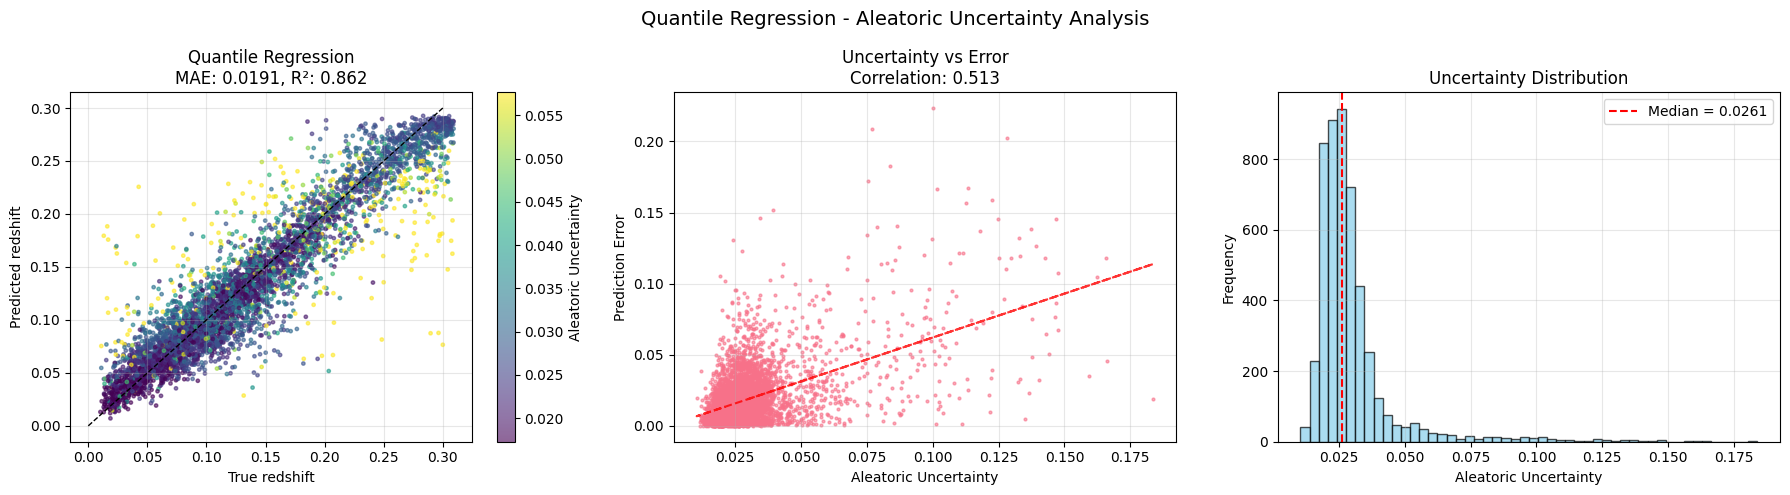

In [12]:
quantile_pred = quantile_model.predict(X_test_scaled, verbose=0)
q05, q25, q50, q75, q95 = [quantile_pred[:, i] for i in range(5)]
quantile_mean_pred = q50  # Median as point estimate
quantile_aleatoric_uncertainty = q75 - q25  # IQR as aleatoric uncertainty

# Calculate coverage
q_coverage_90 = calculate_coverage(y_test, q05, q95, 0.9)

print(f"Quantile Regression MAE: {mean_absolute_error(y_test, quantile_mean_pred):.4f}")
print(f"90% Coverage: {q_coverage_90:.3f}")
print(f"Mean Aleatoric σ (IQR): {np.mean(quantile_aleatoric_uncertainty):.4f}")

# Plot Quantile results
plot_uncertainty_method(y_test, quantile_mean_pred, quantile_aleatoric_uncertainty,
                       "Quantile Regression", "Aleatoric")

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# Conformal Prediction
# ═══════════════════════════════════════════════════════════════════════════════

print("\n5. Training Conformal Prediction (Distribution-free Coverage Guarantees)...")

class QuantileConformalPredictor:
    """
    Conformal Prediction for guaranteed coverage intervals
    Epistemic uncertainty through calibration-based intervals
    """
    def __init__(self, base_model, alpha=0.1):
        self.base_model = base_model
        self.alpha = alpha  # Miscoverage rate
        self.conformal_quantile = None

    def fit(self, X_train, y_train, X_cal, y_cal):
        # Train base model
        self.base_model.fit(X_train, y_train, epochs=20, batch_size=1024,
                           validation_split=0.2, verbose=2,
                           callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

        # Calibration: compute non-conformity scores
        cal_predictions = self.base_model.predict(X_cal, verbose=0).flatten()
        scores = np.abs(y_cal - cal_predictions)

        # Compute conformal quantile for guaranteed coverage
        n_cal = len(scores)
        q_level = np.ceil((n_cal + 1) * (1 - self.alpha)) / n_cal
        self.q_level = min(q_level, 1.0)
        self.conformal_quantile = np.quantile(scores, self.q_level)

        print(f"  Conformal quantile ({100*(1-self.alpha):.0f}% coverage): {self.conformal_quantile:.4f}")
        return self

    def predict(self, X_test):
        predictions = self.base_model.predict(X_test, verbose=0).flatten()
        # Fixed-width intervals based on calibration
        lower = predictions - self.conformal_quantile
        upper = predictions + self.conformal_quantile
        width = upper - lower

        return {
            'prediction': predictions,
            'lower': lower,
            'upper': upper,
            'width': width  # This represents epistemic uncertainty
        }

# Split training data for conformal prediction
X_train_cp, X_cal_cp, y_train_cp, y_cal_cp = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Create and train conformal predictor
base_model_cp = create_baseline_model(X_train_scaled.shape[1])
base_model_cp.compile(optimizer='adam', loss='mse', metrics=['mae'])

conformal_predictor = QuantileConformalPredictor(base_model_cp, alpha=0.1)
conformal_predictor.fit(X_train_cp, y_train_cp, X_cal_cp, y_cal_cp)


5. Training Conformal Prediction (Distribution-free Coverage Guarantees)...
Epoch 1/20
497/497 - 9s - 18ms/step - loss: 0.0018 - mae: 0.0263 - val_loss: 9.7222e-04 - val_mae: 0.0213
Epoch 2/20
497/497 - 1s - 2ms/step - loss: 9.2003e-04 - mae: 0.0209 - val_loss: 9.0676e-04 - val_mae: 0.0207
Epoch 3/20
497/497 - 1s - 2ms/step - loss: 8.9647e-04 - mae: 0.0206 - val_loss: 9.0086e-04 - val_mae: 0.0207
Epoch 4/20
497/497 - 1s - 2ms/step - loss: 8.7906e-04 - mae: 0.0204 - val_loss: 8.9549e-04 - val_mae: 0.0206
Epoch 5/20
497/497 - 1s - 2ms/step - loss: 8.6790e-04 - mae: 0.0202 - val_loss: 8.9316e-04 - val_mae: 0.0205
Epoch 6/20
497/497 - 1s - 2ms/step - loss: 8.5680e-04 - mae: 0.0201 - val_loss: 8.8504e-04 - val_mae: 0.0203
Epoch 7/20
497/497 - 1s - 2ms/step - loss: 8.4839e-04 - mae: 0.0200 - val_loss: 8.8299e-04 - val_mae: 0.0204
Epoch 8/20
497/497 - 1s - 2ms/step - loss: 8.4247e-04 - mae: 0.0199 - val_loss: 8.6650e-04 - val_mae: 0.0201
Epoch 9/20
497/497 - 1s - 2ms/step - loss: 8.3630e-04 

Conformal Prediction MAE: 0.0193
Actual 90% coverage: 0.900 (theoretical guarantee: ≥90%)
Mean Epistemic σ: 0.0419


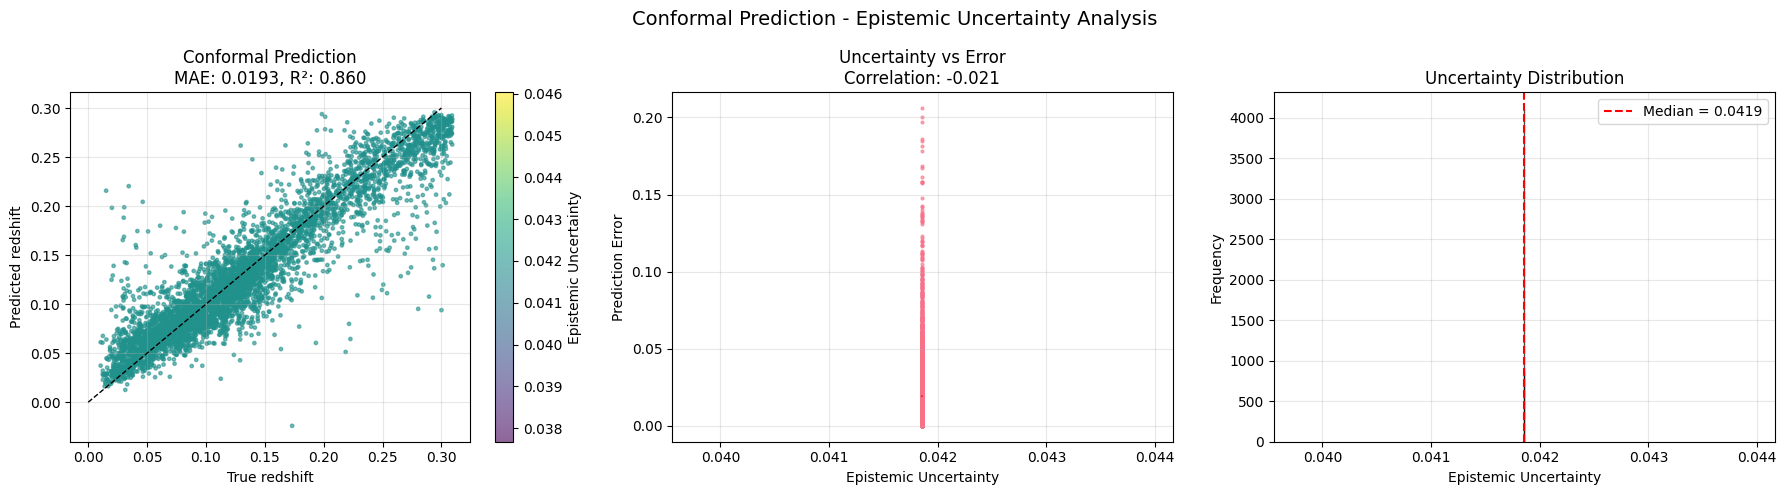


PART II: ALEATORIC UNCERTAINTY METHODS
(Data Uncertainty - 'How noisy is this measurement?')


In [15]:
# Generate conformal predictions
conformal_results = conformal_predictor.predict(X_test_scaled)
conformal_pred = conformal_results['prediction']
conformal_epistemic_uncertainty = conformal_results['width'] / 2  # Half-width as uncertainty

# Calculate coverage
conformal_coverage = calculate_coverage(y_test, conformal_results['lower'],
                                       conformal_results['upper'], 0.9)

print(f"Conformal Prediction MAE: {mean_absolute_error(y_test, conformal_pred):.4f}")
print(f"Actual 90% coverage: {conformal_coverage:.3f} (theoretical guarantee: ≥90%)")
print(f"Mean Epistemic σ: {np.mean(conformal_epistemic_uncertainty):.4f}")



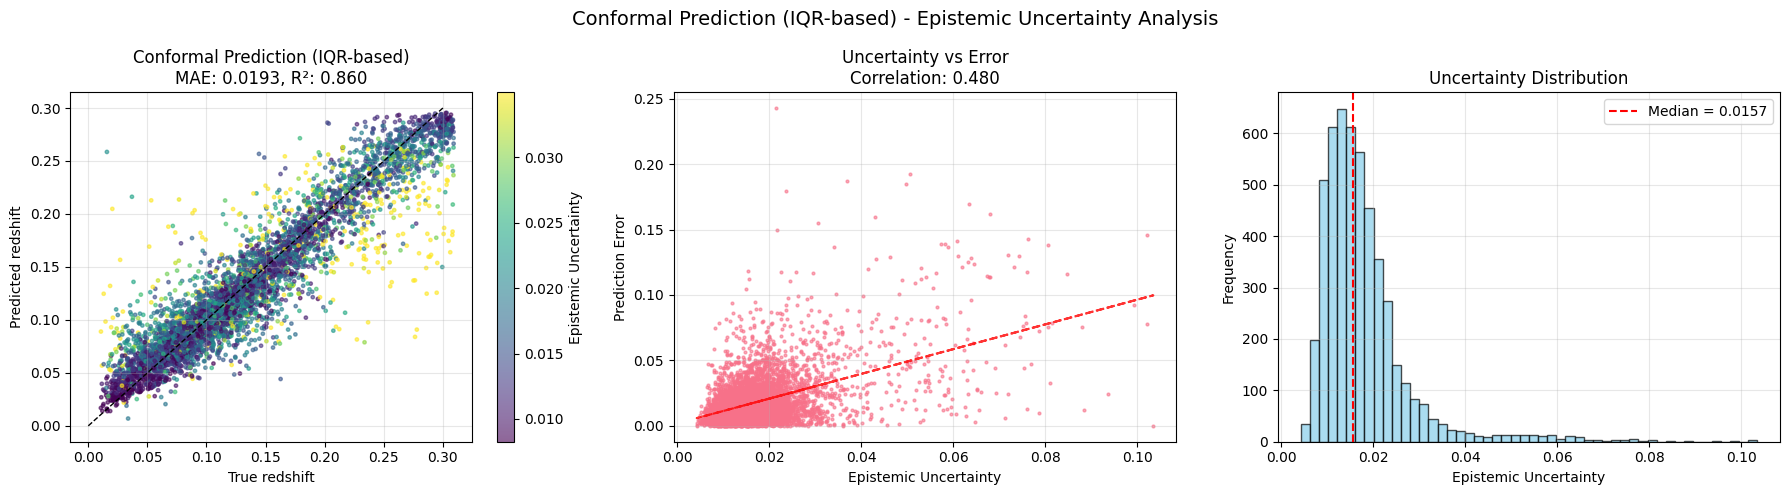

Original uniform uncertainty range: [0.0419, 0.0419]
New IQR-based uncertainty range: [0.0035, 0.1138]
Mean IQR-based uncertainty: 0.0182


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# Local IQR-based Uncertainty
# ═══════════════════════════════════════════════════════════════════════════════

from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr

def compute_local_iqr_uncertainty(X_test, X_cal, cal_residuals, n_neighbors=50):
    """
    Compute local IQR-based uncertainty for each test point
    """
    # Fit nearest neighbors on calibration data
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nbrs.fit(X_cal) # X_cal is already a numpy array due to previous scaling

    # Find neighbors for each test point
    # indices will be positional indices relative to X_cal
    distances, indices = nbrs.kneighbors(X_test)

    local_uncertainties = []
    for i in range(X_test.shape[0]):
        # Get residuals of nearest neighbors using .iloc for positional indexing
        # cal_residuals is a pandas Series, so we need .iloc
        neighbor_residuals = cal_residuals.iloc[indices[i]]
        # Use IQR as local uncertainty measure
        local_iqr = iqr(neighbor_residuals)
        local_uncertainties.append(local_iqr)

    return np.array(local_uncertainties)


cal_predictions = conformal_predictor.base_model.predict(X_cal_cp, verbose=0).flatten()
cal_residuals = np.abs(y_cal_cp - cal_predictions)

conformal_epistemic_uncertainty = compute_local_iqr_uncertainty(
    X_test_scaled, X_cal_cp, cal_residuals, n_neighbors=50
)

plot_uncertainty_method(y_test, conformal_pred, conformal_epistemic_uncertainty,
                       "Conformal Prediction (IQR-based)", "Epistemic")


print(f"Original uniform uncertainty range: [{np.min(conformal_results['width']/2):.4f}, {np.max(conformal_results['width']/2):.4f}]")
print(f"New IQR-based uncertainty range: [{np.min(conformal_epistemic_uncertainty):.4f}, {np.max(conformal_epistemic_uncertainty):.4f}]")
print(f"Mean IQR-based uncertainty: {np.mean(conformal_epistemic_uncertainty):.4f}")